# CIFAR-10

CIFAR-10 dataset: http://www.cs.toronto.edu/~kriz/cifar.html

#### Cieľ zadania: Klasifikácia obrázku jednej z nasledujúcich tried:
• 0: airplane\
• 1: automobile\
• 2: bird\
• 3: cat\
• 4: deer\
• 5: dog\
• 6: frog\
• 7: horse\
• 8: ship\
• 9: truck

In [130]:
from matplotlib import pyplot
from keras.datasets import cifar10

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [131]:
def countValues(data):
    unique_vals, counts = np.unique(data, return_counts=True)

    for val, count in zip(unique_vals, counts):
        print("Class {}: {} records".format(val, count))

In [132]:
def dataNormalisation(data):
    return data.astype('float32') / 255.0

In [133]:
dataClass = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [134]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

print('Train dataset:\n X=%s\n y=%s\n' % (X_train.shape, y_train.shape))
print('Validation dataset:\n X=%s\n y=%s' % (X_val.shape, y_val.shape))

Train dataset:
 X=(50000, 32, 32, 3)
 y=(50000, 1)

Validation dataset:
 X=(10000, 32, 32, 3)
 y=(10000, 1)


In [135]:
countValues(y_train)

Class 0: 5000 records
Class 1: 5000 records
Class 2: 5000 records
Class 3: 5000 records
Class 4: 5000 records
Class 5: 5000 records
Class 6: 5000 records
Class 7: 5000 records
Class 8: 5000 records
Class 9: 5000 records


In [136]:
countValues(y_val)

Class 0: 1000 records
Class 1: 1000 records
Class 2: 1000 records
Class 3: 1000 records
Class 4: 1000 records
Class 5: 1000 records
Class 6: 1000 records
Class 7: 1000 records
Class 8: 1000 records
Class 9: 1000 records


Normalizacia dat do intervalu 0 - 1

In [137]:
X_train = dataNormalisation(X_train)
X_val = dataNormalisation(X_val)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

In [138]:
countValues(y_val)

Class 0: 497 records
Class 1: 482 records
Class 2: 507 records
Class 3: 504 records
Class 4: 500 records
Class 5: 511 records
Class 6: 494 records
Class 7: 507 records
Class 8: 494 records
Class 9: 504 records


In [139]:
countValues(y_test)

Class 0: 503 records
Class 1: 518 records
Class 2: 493 records
Class 3: 496 records
Class 4: 500 records
Class 5: 489 records
Class 6: 506 records
Class 7: 493 records
Class 8: 506 records
Class 9: 496 records


### Dáta:
• RGB obrázky v rozmeroch 32x32x3\
• obrázky rozdelené do 10 tried

Trénovacích vzoriek: 50000 - každá trieda má 5000 vzoriek\
Validačných vzoriek: 10000 - každá trieda má 1000 vzoriek\
&emsp;&emsp;&emsp;    • validačný dataset - 5000 vzoriek\
&emsp;&emsp;&emsp;    • testovací dataset - 5000 vzoriek

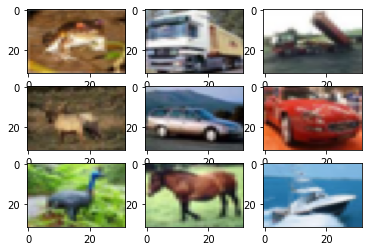

In [140]:
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(X_train[i], aspect='auto')
plt.show()

In [141]:
print('Class:')
for i in range(9):
    print(y_train[i], '-', dataClass[y_train[i][0]])

Class:
[6] - frog
[9] - truck
[9] - truck
[4] - deer
[1] - automobile
[1] - automobile
[2] - bird
[7] - horse
[8] - ship


Normalizacia dat - hodnoty pixelov jednotlivych obrazkov stlacime do intervalu 0 - 1.\
Better gradient propagation - stability of gradient \
Faster convergence - because normalization can help to reduce the scale difference between features \
Robustness to input variations - network can be made more invariant to variations in lighting, contrast, and other image properties

In [142]:
# one hot encodeing
trainY = tf.keras.utils.to_categorical(y_train)
valY = tf.keras.utils.to_categorical(y_val)
testY = tf.keras.utils.to_categorical(y_test)

In [143]:
print(trainY[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [144]:
print(y_train[1])

[9]


#### One hot encoding

In [145]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, trainY, epochs=10, validation_data=(X_val, valY))

test_loss, test_acc = model.evaluate(X_test, testY)

Epoch 1/10
1563/1563 [==============================] - 62s 39ms/step - loss: 1.3671 - accuracy: 0.5112 - val_loss: 1.1301 - val_accuracy: 0.6006
Epoch 2/10
1563/1563 [==============================] - 60s 38ms/step - loss: 0.9816 - accuracy: 0.6581 - val_loss: 0.9316 - val_accuracy: 0.6772
Epoch 3/10
1563/1563 [==============================] - 62s 40ms/step - loss: 0.7999 - accuracy: 0.7214 - val_loss: 0.8796 - val_accuracy: 0.6976
Epoch 4/10
1563/1563 [==============================] - 59s 38ms/step - loss: 0.6541 - accuracy: 0.7715 - val_loss: 0.9244 - val_accuracy: 0.6888
Epoch 5/10
1563/1563 [==============================] - 59s 37ms/step - loss: 0.5188 - accuracy: 0.8189 - val_loss: 0.9721 - val_accuracy: 0.6822
Epoch 6/10
1563/1563 [==============================] - 66s 42ms/step - loss: 0.3931 - accuracy: 0.8625 - val_loss: 0.9972 - val_accuracy: 0.7120
Epoch 7/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.2853 - accuracy: 0.9006 - val_loss: 1.1283 -

In [146]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 1.4965558052062988
Test accuracy: 0.7085999846458435


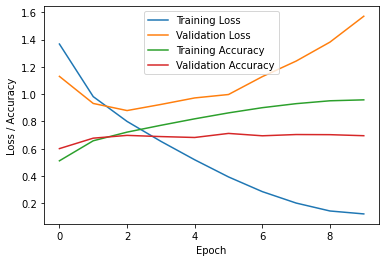

In [147]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

#### Without OHE

In [148]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 56s 35ms/step - loss: 1.3505 - accuracy: 0.5205 - val_loss: 1.2422 - val_accuracy: 0.5744
Epoch 2/10
1563/1563 [==============================] - 54s 35ms/step - loss: 0.9837 - accuracy: 0.6536 - val_loss: 0.9806 - val_accuracy: 0.6554
Epoch 3/10
1563/1563 [==============================] - 54s 35ms/step - loss: 0.8064 - accuracy: 0.7168 - val_loss: 0.9301 - val_accuracy: 0.6774
Epoch 4/10
1563/1563 [==============================] - 55s 35ms/step - loss: 0.6558 - accuracy: 0.7718 - val_loss: 0.9163 - val_accuracy: 0.6952
Epoch 5/10
1563/1563 [==============================] - 54s 34ms/step - loss: 0.5142 - accuracy: 0.8213 - val_loss: 0.9245 - val_accuracy: 0.7034
Epoch 6/10
1563/1563 [==============================] - 54s 35ms/step - loss: 0.3865 - accuracy: 0.8658 - val_loss: 1.0238 - val_accuracy: 0.7012
Epoch 7/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.2757 - accuracy: 0.9047 - val_loss: 1.1125 -

In [149]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 1.5857616662979126
Test accuracy: 0.6955999732017517


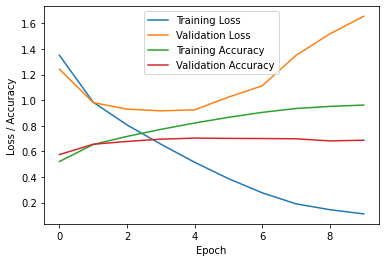

In [150]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

#### Augmentovany a normalizovany dataset

In [151]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

X_train = dataNormalisation(X_train)
X_val = dataNormalisation(X_val)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

Augmentacia dat, zvysenie poctu obrazkov o dvojnasobok

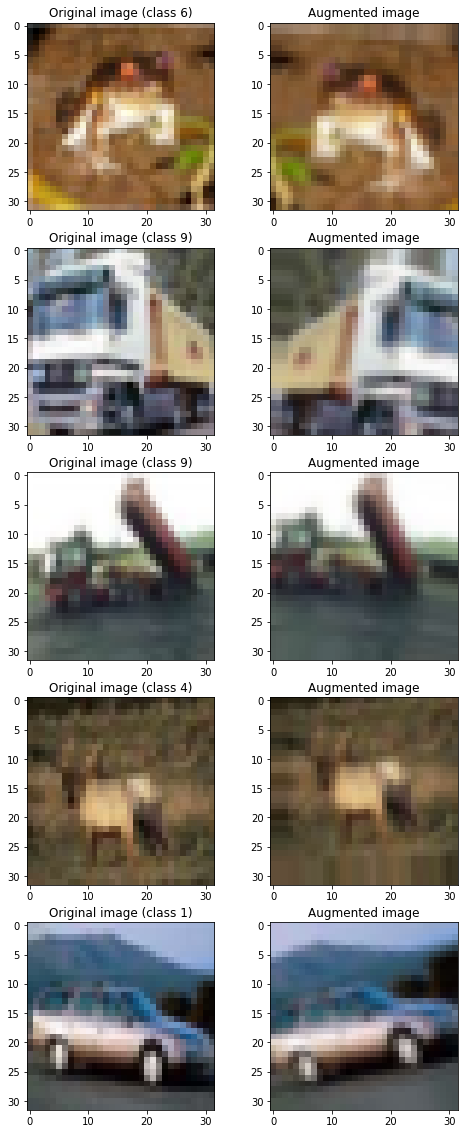

In [152]:
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1)

# Generate augmented images and labels
augmented_images = []
augmented_labels = []
for i in range(X_train.shape[0]):
    # Generate augmented image
    augmented_image = datagen.random_transform(X_train[i])
    # Append augmented image to list of augmented images
    augmented_images.append(augmented_image)
    # Append corresponding label to list of augmented labels
    augmented_labels.append(y_train[i])

# Convert the list of augmented images and labels to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate original images and labels with augmented images and labels
X_train = np.concatenate((X_train, augmented_images))
y_train = np.concatenate((y_train, augmented_labels))

# Plot the original and augmented images
fig, axes = plt.subplots(5, 2, figsize=(8, 20))
for i in range(5):
    # Plot the original image
    axes[i, 0].imshow(X_train[i])
    axes[i, 0].set_title(f"Original image (class {y_train[i][0]})")

    # Plot the augmented image
    axes[i, 1].imshow(augmented_images[i])
    axes[i, 1].set_title("Augmented image")
plt.show()

In [153]:
print(X_train.shape)
print(y_train.shape)

(100000, 32, 32, 3)
(100000, 1)


In [154]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
3125/3125 [==============================] - 114s 36ms/step - loss: 1.3021 - accuracy: 0.5340 - val_loss: 1.0408 - val_accuracy: 0.6410
Epoch 2/5
3125/3125 [==============================] - 126s 40ms/step - loss: 0.9542 - accuracy: 0.6642 - val_loss: 0.9232 - val_accuracy: 0.6842
Epoch 3/5
3125/3125 [==============================] - 114s 36ms/step - loss: 0.7812 - accuracy: 0.7276 - val_loss: 0.8594 - val_accuracy: 0.7080
Epoch 4/5
3125/3125 [==============================] - 111s 35ms/step - loss: 0.6453 - accuracy: 0.7753 - val_loss: 0.8032 - val_accuracy: 0.7340
Epoch 5/5
157/157 [==============================] - 1s 7ms/step - loss: 0.8494 - accuracy: 0.7406


In [155]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.8494152426719666
Test accuracy: 0.7405999898910522


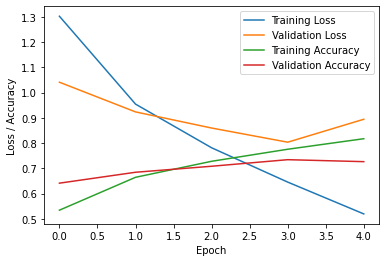

In [156]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()